# Project - Cat or Dag Classifier
# Table of Content
<ul>
    <li><a href='#Introduction'>Introduction</a></li>
    <li><a href='#Dataset'>Dataset</a></li>
    <li><a href='#Preprocessing'>Data Preprocessing</a></li>
    <li><a href='#Architecture'>Model Architecture</a></li>
    <li><a href='#Training'>Model Training</a></li>
    <li><a href='#Evaluation'>Model Evaluation</a></li>
    <li><a href='#Conclusion'>Conclusion</a></li>
</ul>

# Introduction
<a id='Introduction'></a>
This project focuses on creating a deep learning model that can classify images as either cat or dog. Using a convolutional neural network (CNN), the model is trained to recognize and differentiate between these two animals by learning from a dataset of labeled images.

# Dataset
<a id='Dataset'></a>
This dataset consists of two image classes: cats and dogs, making it ideal for binary classification tasks in computer vision. The dataset can be effectively used to train models that distinguish between these two animal classes, providing a strong foundation for exploring deep learning applications in image recognition.<br>
<br>
The dataset contains a total of 14,000 images, with an equal distribution between cats and dogs. For training, there are 5,000 images of dogs and 5,000 images of cats, allowing the model to learn from a balanced set of examples. The remaining 4,000 images are reserved for testing, comprising 2,000 images of dogs and 2,000 images of cats. <br>
<br>
The link of the dataset
<a href="https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat">Dog vs Cat</a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing
<a id='Preprocessing'></a>

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Cat-Dog-CNN-Classifier/data/train', transform=transform)
test_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Colab Notebooks/Cat-Dog-CNN-Classifier/data/test", transform=transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Architecture
<a id='Architecture'></a>

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 256 * 14 * 14)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)


        return x

model = CNN()

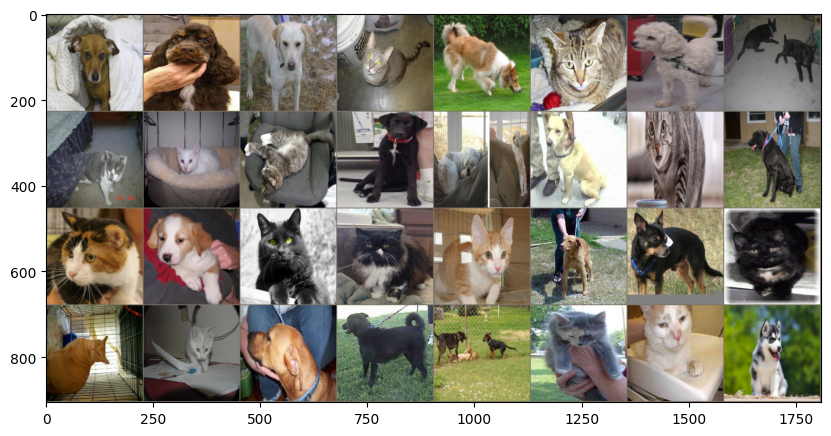

In [7]:
def imshow(img, title=None):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    npimg = img.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Model Training
<a id='Training'></a>

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs, labels

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_samples

    print(f'Epoch ({epoch + 1}/{num_epochs}), Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch (1/10), Loss: 0.6638, Accuracy: 58.26%
Epoch (2/10), Loss: 0.6126, Accuracy: 66.39%
Epoch (3/10), Loss: 0.5357, Accuracy: 73.79%
Epoch (4/10), Loss: 0.4667, Accuracy: 78.20%
Epoch (5/10), Loss: 0.3990, Accuracy: 82.22%
Epoch (6/10), Loss: 0.3187, Accuracy: 86.49%
Epoch (7/10), Loss: 0.2165, Accuracy: 91.33%
Epoch (8/10), Loss: 0.1368, Accuracy: 94.91%
Epoch (9/10), Loss: 0.0783, Accuracy: 97.30%
Epoch (10/10), Loss: 0.0608, Accuracy: 98.06%


# Model Evaluation
<a id='Evaluation'></a>

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

all_labels = []
all_predictions = []

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images, labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f"Accuracy: {100 * correct / total} %")

Accuracy: 78.45 %


In [12]:
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[777 223]
 [208 792]]


In [13]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1000
           1       0.78      0.79      0.79      1000

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



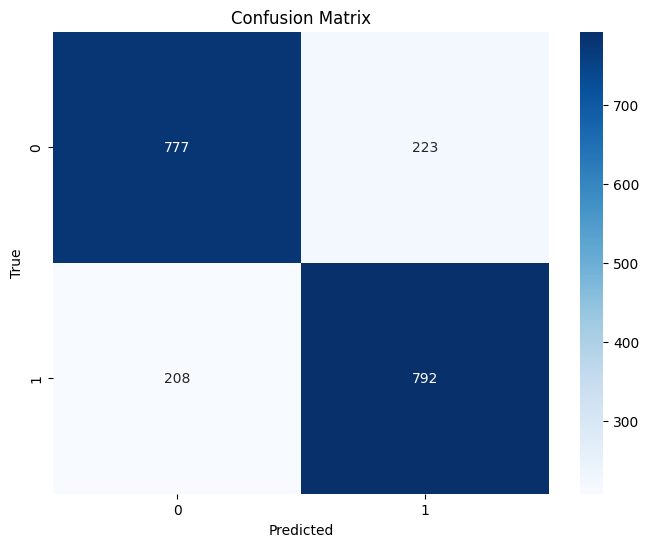

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Conclusion
<a id='Conclusion'></a>

The cat or dog classifier shows how machine learning can tell the difference between animals. By using convolutional neural networks (CNNs), the model was pretty good at telling apart cats and dogs, but it still needs improvement for tricky cases and different types of data.<br>
<br>
Some challenges include telling apart similar breeds, dealing with poor lighting, and handling strange angles. To make the model better, we could use more types of images, add data to make it more varied, and try advanced methods like transfer learning. When using the model in real life, we need to make sure it works well and is fair.